In [21]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [29]:
import csv
def readMyFile(filename):
    x = []
    y = []
    with open(filename) as csvDataFile:
        MainFoil = csv.reader(csvDataFile)
        for row in MainFoil:
            x.append(row[0])
            y.append(row[1])
        return x, y

x_MainFoil, y_MainFoil = readMyFile('MainFoil_N=100.csv')
x_FlapFoil, y_FlapFoil = readMyFile('FlapFoil_N=100.csv')

(-0.7, 0.5)

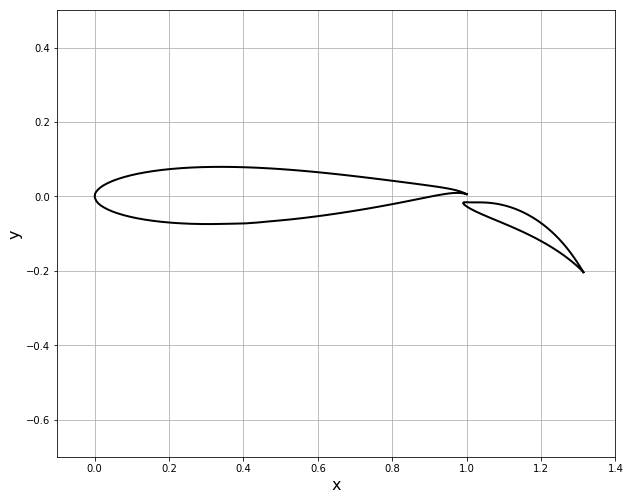

In [31]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, x_FlapFoil, y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.7, 0.5)

In [54]:
x_mainfoil = numpy.asarray(x_MainFoil, dtype=float)
y_mainfoil = numpy.asarray(y_MainFoil, dtype=float)
x_flapfoil = numpy.asarray(x_FlapFoil, dtype=float)
y_flapfoil = numpy.asarray(y_FlapFoil, dtype=float)

In [32]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0  

In [70]:
def define_panels(x, y, N):
    R = (x.max() - x.min()) / 2  
    x_center = (x.max() + x.min()) / 2  
    x_circle = x_center + R * numpy.cos(numpy.linspace(0.0, 2 * math.pi, N + 1))
    
    x_ends = numpy.copy(x_circle)  
    y_ends = numpy.empty_like(x_ends)  

    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])  
    
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

(-0.1, 0.1)

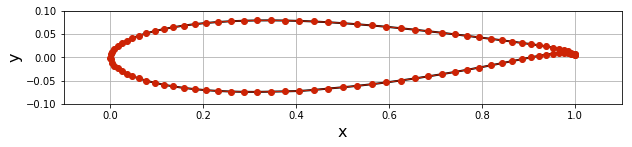

In [71]:
N = 100                           
panels = define_panels(x_mainfoil, y_mainfoil, N)  

width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_mainfoil, y_mainfoil, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)

In [69]:
def get_attackangle(X, Y, x, y):
    X_f = (X - x) * numpy.cos(math.pi*(1/6)) + (Y - y) * numpy.sin(math.pi*(1/6))
    Y_f = -(X - x) * numpy.sin(math.pi*(1/6)) + (Y - y) * numpy.cos(math.pi*(1/6))
    return X_f, Y_f